In [1]:
from pathlib import Path
import numpy as np
from crawfish.utils.testing import EXAMPLE_CALC_DIRS_DIR
from crawfish.core.operations.vector import get_gauss_smear_spectrum, get_lti_spectrum,get_uneven_integrated_array
from crawfish.core.elecdata import ElecData, los_projs_for_bands
from crawfish.funcs.general import SIGMA_DEFAULT, RES_DEFAULT
from crawfish.utils.typing import REAL_DTYPE, cs_formatter, COMPLEX_DTYPE
import matplotlib.pyplot as plt

n2_calcdir = EXAMPLE_CALC_DIRS_DIR / "N2_bare_min"
edata = ElecData(n2_calcdir)
#edata.norm_projs_t2()
nproj = edata.nproj
nspin = edata.nspin
nbands = edata.nbands
nstates = edata.nstates
kfolding = edata.kfolding
nk = np.prod(kfolding)
proj_sabcju = edata.proj_sabcju.copy()
proj_tju = edata.proj_tju.copy()
e_sabcj = edata.e_sabcj.copy()
occ_sabcj = edata.occ_sabcj.copy()
s,a,b,c,j = occ_sabcj.shape
t = s*a*b*c
occ_tj = occ_sabcj.reshape(t,j)
wk_sabc = edata.wk_sabc.copy()
wk_t = wk_sabc.flatten()
wk_jsabc = np.array([wk_sabc for _ in range(nbands)], dtype=REAL_DTYPE)
wk_sabcj = np.moveaxis(wk_jsabc, 0, -1)

In [2]:
nelec = 0
for j in range(nbands):
    for t in range(nstates):
        nelec += occ_tj[t,j]*wk_t[t]
print(nelec)

9.999982


In [3]:
nelec = 0
for j in range(nproj, nbands):
    for t in range(nstates):
        nelec += occ_tj[t,j]*wk_t[t]
print(nelec)

0.0


In [4]:
alist = list(range(edata.nbands))
print(alist[:nproj])
print(alist[nproj:])

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 14]


In [5]:
nproj = edata.nproj
nspin = edata.nspin
nbands = edata.nproj
nstates = edata.nstates
kfolding = edata.kfolding
nk = np.prod(kfolding)
proj_sabcju = edata.proj_sabcju.copy()[:,:,:,:,:nproj,:]
proj_tju = edata.proj_tju.copy()[:,:nproj,:]
e_sabcj = edata.e_sabcj.copy()[:,:,:,:,:nproj]
occ_sabcj = edata.occ_sabcj.copy()[:,:,:,:,:nproj]
s,a,b,c,j = occ_sabcj.shape
t = s*a*b*c
occ_tj = occ_sabcj.reshape(t,j)
wk_sabc = edata.wk_sabc.copy()
wk_t = wk_sabc.flatten()
wk_jsabc = np.array([wk_sabc for _ in range(nbands)], dtype=REAL_DTYPE)
wk_sabcj = np.moveaxis(wk_jsabc, 0, -1)

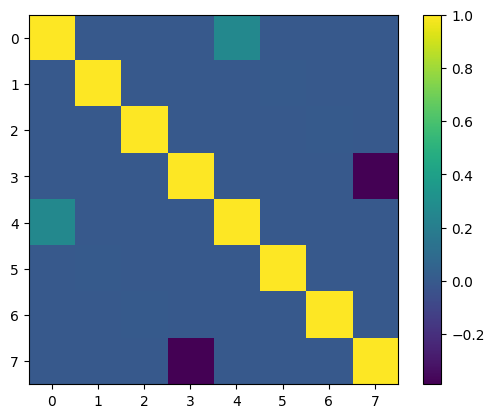

In [6]:

def get_proj_tju_for_s_uv(proj_tju, wk_t):
    proj_tju_for_s_uv = normalize_proj_tju_for_s_uv(proj_tju.copy(), wk_t)
    check_proj_tju_for_s_uv(proj_tju_for_s_uv, wk_t)
    return proj_tju_for_s_uv

def normalize_proj_tju_for_s_uv(proj_tju_for_s_uv, wk_t):
    for u in range(nproj):
        asum = 0
        for t in range(nstates):
            asum2 = 0
            for j in range(nbands):
                asum2 += (proj_tju_for_s_uv[t, j, u].conj()*proj_tju_for_s_uv[t, j, u])
            asum += asum2*wk_t[t]
        proj_tju_for_s_uv[:,:,u] *= (1/asum)**0.5
    return proj_tju_for_s_uv

def check_proj_tju_for_s_uv(proj_tju_for_s_uv, wk_t):
    for u in range(nproj):
        asum = 0
        for t in range(nstates):
            asum2 = 0
            for j in range(nbands):
                asum2 += (proj_tju_for_s_uv[t, j, u].conj()*proj_tju_for_s_uv[t, j, u])
            asum += asum2*wk_t[t]
        if not np.isclose(asum, 1):
            raise ValueError(f"u={u} is not normalized (S_uu={asum})")

def get_s_uv(proj_tju, wk_t):
    s_uv = np.zeros((nproj, nproj), dtype=COMPLEX_DTYPE)
    proj_tju_for_s_uv = get_proj_tju_for_s_uv(proj_tju, wk_t)
    for u in range(nproj):
        for v in range(nproj):
            asum = 0
            for t in range(nstates):
                asum2 = 0
                for j in range(nbands):
                    # Change if S must be real
                    asum2 += 1*(proj_tju_for_s_uv[t, j, u].conj()*proj_tju_for_s_uv[t, j, v])
                    # asum2 += 0.5*(proj_tju_for_s_uv[t, j, u].conj()*proj_tju_for_s_uv[t, j, v]+proj_tju_for_s_uv[t, j, v].conj()*proj_tju_for_s_uv[t, j, u])
                asum += asum2*wk_t[t]
            s_uv[u, v] = asum
    return s_uv

#

def get_proj_tju_for_s_uv_t(proj_tju, wk_t):
    proj_tju_for_s_uv_t = normalize_proj_tju_for_s_uv_t(proj_tju.copy(), wk_t)
    check_proj_tju_for_s_uv_t(proj_tju_for_s_uv_t, wk_t)
    return proj_tju_for_s_uv_t

def normalize_proj_tju_for_s_uv_t(proj_tju_for_s_uv_t, wk_t):
    for u in range(nproj):
        for t in range(nstates):
            asum = 0
            for j in range(nbands):
                asum += (proj_tju_for_s_uv_t[t, j, u].conj()*proj_tju_for_s_uv_t[t, j, u])
            proj_tju_for_s_uv_t[t,:,u] *= (1/asum)**0.5
    return proj_tju_for_s_uv_t

def check_proj_tju_for_s_uv_t(proj_tju_for_s_uv_t, wk_t):
    for u in range(nproj):
        for t in range(nstates):
            asum = 0
            for j in range(nbands):
                asum += (proj_tju_for_s_uv_t[t, j, u].conj()*proj_tju_for_s_uv_t[t, j, u])
            if not np.isclose(asum, 1):
                raise ValueError(f"u={u} is not normalized (S_uu={asum})")

def get_s_uv_t(proj_tju, wk_t):
    s_uv_t = np.zeros((nproj, nproj, nstates), dtype=COMPLEX_DTYPE)
    proj_tju_for_s_uv_t = get_proj_tju_for_s_uv_t(proj_tju, wk_t)
    for u in range(nproj):
        for v in range(nproj):
            for t in range(nstates):
                for j in range(nbands):
                    s_uv_t[u,v,t] += 1*(proj_tju_for_s_uv_t[t, j, u].conj()*proj_tju_for_s_uv_t[t, j, v])
    return s_uv_t

# def get_dualu_proj_tju(proj_tju_for_s_uv, wk_t):
#     s_uv_t = get_s_uv_t(proj_tju_for_s_uv, wk_t)
#     inv_s_t_uv = np.array([np.linalg.inv(s_uv_t[:,:,t]) for t in range(nstates)], dtype=COMPLEX_DTYPE)
#     inv_s_uv_t = np.moveaxis(inv_s_t_uv, 0, -1)
#     dualu_proj_tju = np.zeros_like(proj_tju_for_s_uv)
#     for u in range(nproj):
#         for t in range(nstates):
#             for v in range(nproj):
#                 for j in range(nbands):
#                     dualu_proj_tju[t, j, u] += inv_s_uv_t[u, v, t]*proj_tju_for_s_uv[t, j, v]

s_uv = get_s_uv(proj_tju, wk_t)
s_uv_t = get_s_uv_t(proj_tju, wk_t)
inv_s_t_uv = np.array([np.linalg.inv(s_uv_t[:,:,t]) for t in range(nstates)], dtype=COMPLEX_DTYPE)
inv_s_uv_t = np.moveaxis(inv_s_t_uv, 0, -1)
plt.imshow(np.real(s_uv_t[:,:,8]))
plt.colorbar()

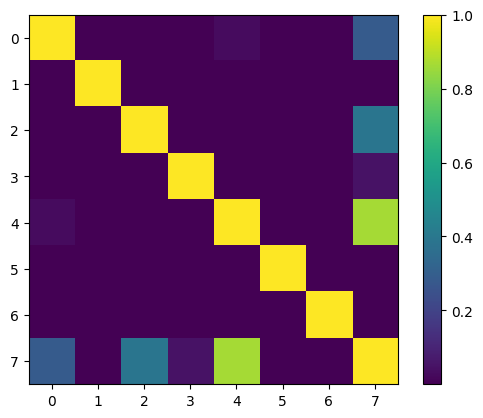

In [7]:

def get_proj_tju_for_r_jk(proj_tju, wk_t):
    proj_tju_for_r_jk = normalize_proj_tju_for_r_jk(proj_tju.copy(), wk_t)
    check_proj_tju_for_r_jk(proj_tju_for_r_jk, wk_t)
    return proj_tju_for_r_jk

def normalize_proj_tju_for_r_jk(proj_tju_for_r_jk, wk_t):
    for j in range(nbands):
        asum = 0
        for t in range(nstates):
            asum2 = 0
            for u in range(nproj):
                asum2 += (proj_tju_for_r_jk[t, j, u].conj()*proj_tju_for_r_jk[t, j, u])
            asum += asum2*wk_t[t]
        proj_tju_for_r_jk[:,j,:] *= (1/asum)**0.5
    return proj_tju_for_r_jk

def check_proj_tju_for_r_jk(proj_tju_for_r_jk, wk_t):
    for j in range(nbands):
        asum = 0
        for t in range(nstates):
            asum2 = 0
            for u in range(nproj):
                asum2 += (proj_tju_for_r_jk[t, j, u].conj()*proj_tju_for_r_jk[t, j, u])
            asum += asum2*wk_t[t]
        if not np.isclose(asum, 1):
            raise ValueError(f"j={j} is not normalized (S_jj={asum})")

def get_r_jk(proj_tju, wk_t):
    r_jk = np.zeros((nbands, nbands), dtype=COMPLEX_DTYPE)
    proj_tju_for_r_jk = get_proj_tju_for_r_jk(proj_tju, wk_t)
    for j in range(nbands):
        for k in range(nbands):
            asum = 0
            for t in range(nstates):
                asum2 = 0
                for u in range(nproj):
                    # Change if S must be real
                    asum2 += 1*(proj_tju_for_r_jk[t, j, u].conj()*proj_tju_for_r_jk[t, k, u])
                    # asum2 += 0.5*(proj_tju_for_s_uv[t, j, u].conj()*proj_tju_for_s_uv[t, j, v]+proj_tju_for_s_uv[t, j, v].conj()*proj_tju_for_s_uv[t, j, u])
                asum += asum2*wk_t[t]
            r_jk[j, k] = asum
    return r_jk

#

def get_proj_tju_for_r_jk_t(proj_tju, wk_t):
    proj_tju_for_r_jk_t = normalize_proj_tju_for_r_jk_t(proj_tju.copy(), wk_t)
    check_proj_tju_for_r_jk_t(proj_tju_for_r_jk_t, wk_t)
    return proj_tju_for_r_jk_t

def normalize_proj_tju_for_r_jk_t(proj_tju_for_r_jk_t, wk_t):
    for j in range(nbands):
        for t in range(nstates):
            asum=0
            for u in range(nproj):
                asum += (proj_tju_for_r_jk_t[t, j, u].conj()*proj_tju_for_r_jk_t[t, j, u])
            proj_tju_for_r_jk_t[t,j,:] *= (1/asum)**0.5
    return proj_tju_for_r_jk_t

def check_proj_tju_for_r_jk_t(proj_tju_for_r_jk, wk_t):
    for j in range(nbands):
        for t in range(nstates):
            asum=0
            for u in range(nproj):
                asum += (proj_tju_for_r_jk[t, j, u].conj()*proj_tju_for_r_jk[t, j, u])
            if not np.isclose(asum, 1):
                raise ValueError(f"j={j} is not normalized (S_jj={asum})")

def get_r_jk_t(proj_tju, wk_t):
    r_jk_t = np.zeros((nbands, nbands, nstates), dtype=COMPLEX_DTYPE)
    proj_tju_for_r_jk_t = get_proj_tju_for_r_jk_t(proj_tju, wk_t)
    for j in range(nbands):
        for k in range(nbands):
            for t in range(nstates):
                for u in range(nproj):
                    r_jk_t[j, k,t] += 1*(proj_tju_for_r_jk_t[t, j, u].conj()*proj_tju_for_r_jk_t[t, k, u])
    return r_jk_t

r_jk = get_r_jk(proj_tju, wk_t)
r_jk_t = get_r_jk_t(proj_tju, wk_t)
inv_r_t_jk = np.array([np.linalg.inv(r_jk_t[:,:,t]) for t in range(nstates)], dtype=COMPLEX_DTYPE)
inv_r_jk_t = np.moveaxis(inv_r_t_jk, 0, -1)
plt.imshow(np.abs(r_jk_t[:,:,8]))
plt.colorbar()

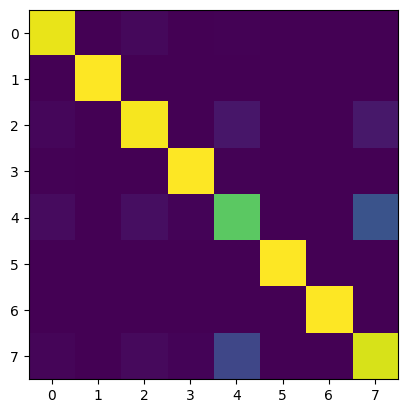

In [13]:
plt.imshow(abs(np.dot(inv_r_jk_t[:,:,8], r_jk_t[:,:,8])))

7.0009656
1.0004811
1.000481
0.9995188
0.99951994
1.000481
0.9995204
0.99951833
1.0004791
0.9999998
1.0
0.99999994
0.9999998
1.0
1.0
0.99999994
1.0


(0.0, 0.1)

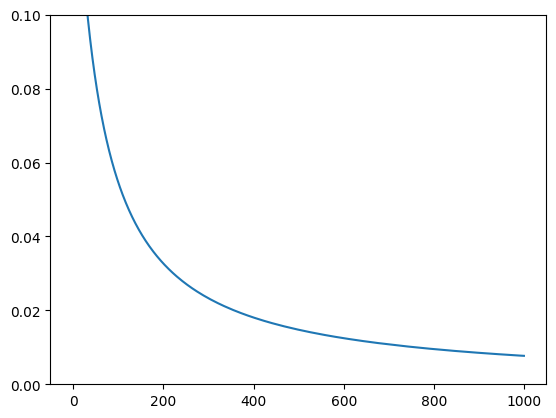

In [42]:
t = 10
proj_tju_for_r_jk_t = get_proj_tju_for_r_jk(proj_tju, wk_t)
r_jk_t = get_r_jk_t(proj_tju, wk_t)
r_proj_ju = proj_tju_for_r_jk_t[t,:,:]

r_jk = r_jk_t[:,:,t]
print(np.linalg.cond(r_jk))
inv_r_jk = np.linalg.inv(r_jk)
proj_tju_for_s_uv_t = get_proj_tju_for_s_uv_t(proj_tju, wk_t)
s_uv_t = get_s_uv_t(proj_tju, wk_t)
s_proj_ju = proj_tju_for_s_uv_t[t,:,:]
nloops=1000
losses = np.zeros(nloops)
for n in range(nloops):
    for j in range(nproj):
        asum = 0
        for u in range(nproj):
            asum += np.abs(s_proj_ju[j,u].conj()*s_proj_ju[j,u])
        s_proj_ju[j,:] *= 1/(asum**0.5)
        losses[n] += abs(1-asum)
    for u in range(nproj):
        asum = 0
        for j in range(nproj):
            asum += np.abs(s_proj_ju[j,u].conj()*s_proj_ju[j,u])
        s_proj_ju[:,u] *= 1/(asum**0.5)
        losses[n] += abs(1-asum)
for j in range(nproj):
    asum = 0
    for u in range(nproj):
        asum += np.abs(s_proj_ju[j,u].conj()*s_proj_ju[j,u])
    print(asum)
for u in range(nproj):
    asum = 0
    for j in range(nproj):
        asum += np.abs(s_proj_ju[j,u].conj()*s_proj_ju[j,u])
    print(asum)
plt.plot(range(nloops), losses)
plt.ylim(0,0.1)

# s_uv = s_uv_t[:,:,t]
# fig, ax = plt.subplots(nrows=3)
# print(np.linalg.cond(s_uv))
# ax[0].imshow(abs(s_uv))
# inv_s_uv = np.linalg.inv(s_uv)
# ax[1].imshow(abs(inv_s_uv))
# dual_s_proj_ju = np.zeros_like(s_proj_ju)
# for u in range(nproj):
#     for v in range(nproj):
#         dual_s_proj_ju[u,:] += inv_s_uv[u,v]*s_proj_ju[v,:]
# # # S_OO = s_proj_ju.conj().T @ inv_s_uv @ s_proj_ju
# # # dual_s_proj_ju = np.linalg.tensordot(inv_s_uv, s_proj_ju, axes=(0,1))
# # dual_s_proj_ju = inv_s_uv.T
# S_00 = np.tensordot(s_proj_ju, dual_s_proj_ju, axes=(0,0))
# ax[2].imshow(abs(S_00))
# # R_OO = r_proj_ju.conj().T @ inv_r_jk @ r_proj_ju
# # ax[0].imshow(np.abs(S_OO))
# # ax[1].imshow(np.abs(R_OO))

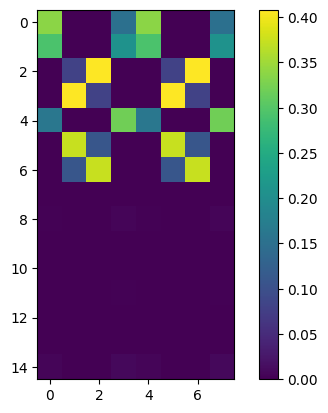

In [9]:
t = 0
plt.imshow(np.abs(edata.proj_tju[t,:,:].conj()*edata.proj_tju[t,:,:]))
plt.colorbar()

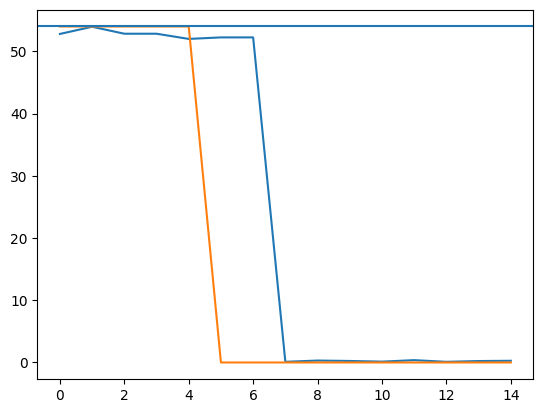

In [10]:
t=2
edata.unnorm_projs()
plt.plot(range(edata.nbands), [np.sum(np.abs(edata.proj_tju[:,j,:].conj()*edata.proj_tju[:,j,:]), axis=(0,1)) for j in range(edata.nbands)])
plt.plot(range(edata.nbands), [np.sum(edata.occ_sabcj[:,:,:,:,j], axis=(0,1,2,3)) for j in range(edata.nbands)])
plt.axhline(y=nstates)

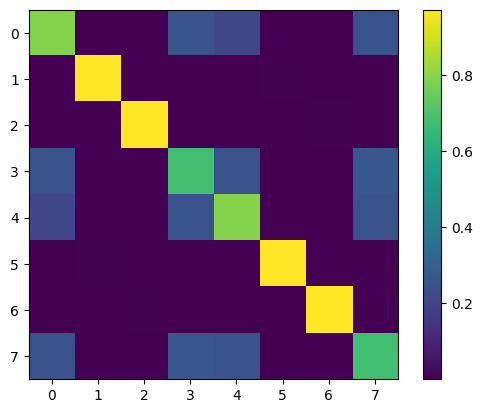

In [11]:
t = 0
plt.imshow(np.abs(np.tensordot(proj_tju[t,:,:].conj().T, proj_tju[t,:,:], axes=([1],[0]))))
plt.colorbar()

3.7907886505126953 3.7907893657684326
2.3162267208099365 2.3162267208099365
5.048538684844971 5.048538684844971
2.86966609954834 2.8696658611297607
3.6269657611846924 3.6269657611846924
2.329650640487671 2.32965087890625
1.88812255859375 1.88812255859375
3.694801092147827 3.6948015689849854
1.868346095085144 1.868346095085144
3.6825268268585205 3.6825273036956787
13.182882308959961 13.182890892028809
2.7540109157562256 2.7540109157562256
3.2018308639526367 3.2018306255340576
22.41629409790039 22.416297912597656
5.717660903930664 5.717660427093506
2.558673858642578 2.558673858642578
5.277617454528809 5.277617454528809
10.936732292175293 10.93673038482666
6.992648124694824 6.992644309997559
2.3515896797180176 2.3515896797180176
3.5491106510162354 3.5491113662719727
8.068572044372559 8.068574905395508
8.114197731018066 8.114197731018066
6.162980556488037 6.162980079650879
147.72848510742188 147.7293243408203
4.361473560333252 4.3614726066589355
8.749992370605469 8.749993324279785
3.484758

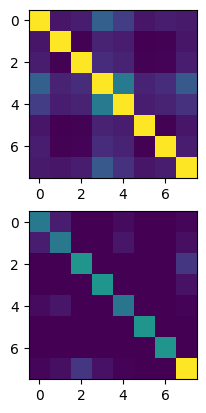

In [173]:


t = 0
nproj_tju=edata.proj_tju.copy()[:,:nproj,:]
nproj_tju[:,-1,:] += np.sum(edata.proj_tju[:,nproj:,:], axis=1)
for j in range(nproj):
    nproj_tju[:,j,:] *= (1/np.sum(np.abs(nproj_tju[:,j,:])**2))**0.5
norm_proj_tju = get_proj_tju_for_s_uv_t(nproj_tju, wk_t)
s_uv_t = get_s_uv_t(norm_proj_tju, wk_t)
r_t_jk = np.array([
    np.tensordot(
        norm_proj_tju[t].conj().T, norm_proj_tju[t], axes=([0],[1]))
        for t in range(nstates)], dtype=COMPLEX_DTYPE)
r_jk_t = np.moveaxis(r_t_jk, 0, -1)
for l in range(nstates):
    print(f"{(np.linalg.cond(s_uv_t[:,:,l]))} {(np.linalg.cond(r_jk_t[:,:,l]))}")
    # print(f"{np.log10(np.linalg.cond(s_uv_t[:,:,l]))} {np.log10(np.linalg.cond(r_jk_t[:,:,l]))}")
fig, ax = plt.subplots(nrows=2)
ax[0].imshow(np.abs(s_uv_t[:,:,0]))
ax[1].imshow(np.abs(r_jk_t[:,:,0]))

# r_jk_t = get_r_jk_t(proj_tju, wk_t)
# r_proj_ju = proj_tju_for_r_jk_t[t,:,:]
# r_jk = r_jk_t[:,:,t]
# inv_r_jk = np.linalg.inv(r_jk)
# proj_tju_for_s_uv_t = get_proj_tju_for_s_uv_t(proj_tju, wk_t)
# s_uv_t = get_s_uv_t(proj_tju, wk_t)
# s_proj_ju = proj_tju_for_s_uv_t[t,:,:]
# s_uv = s_uv_t[:,:,t]
# inv_s_uv = np.linalg.inv(s_uv)
# fig, ax = plt.subplots(nrows=2)
# S_OO = s_proj_ju.conj().T @ inv_s_uv @ s_proj_ju
# R_OO = r_proj_ju.conj().T @ inv_r_jk @ r_proj_ju
# ax[0].imshow(np.abs(S_OO))
# ax[1].imshow(np.abs(R_OO))

7.114234
(0.0551669-0.025461614j)


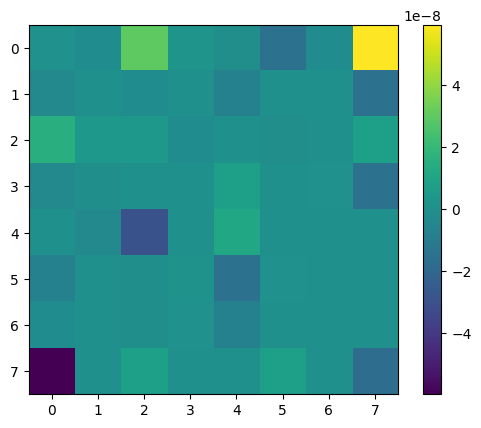

In [135]:
proj_tju_for_r_jk_t = get_proj_tju_for_r_jk_t(proj_tju, wk_t)
t = -1
j = 0
k = 3
ex_proj_ju1 = proj_tju_for_r_jk_t[t,j,:]
ex_proj_ju2 = proj_tju_for_r_jk_t[t,k,:]
ex_r_jk = r_jk_t[:,:,t]
inv_ex_r_jk = np.linalg.inv(ex_r_jk)
print(np.linalg.cond(ex_r_jk))
# plt.imshow(np.abs(np.tensordot(inv_ex_r_jk, ex_r_jk, axes=([1],[0])))**2)
plt.imshow(np.imag(ex_r_jk @ inv_ex_r_jk))
plt.colorbar()
print(np.dot(ex_proj_ju1.conj().T, inv_ex_r_jk @ ex_proj_ju2))
# dualj_proj_ju = np.dot(inv_ex_r_jk, proj_tju_for_r_jk_t[t,:,:])
# ex_dualj_proj_ju = np.zeros_like(ex_proj_ju1)
# for u in range(nproj):
#     ex_dualj_proj_ju += inv_ex_r_jk[k]*proj_tju_for_r_jk_t[t,:,u]
# ex_overlap = np.dot(ex_proj_ju1.conj(), ex_dualj_proj_ju)
# print(ex_overlap)

In [87]:
proj_tju_for_r_jk_t = get_proj_tju_for_r_jk_t(proj_tju, wk_t)
dualj_proj_tju_for_r_jk_t = np.zeros_like(proj_tju_for_r_jk_t)
for t in range(nstates):
    dualj_proj_tju_for_r_jk_t[t, :, :] += np.tensordot(
        inv_r_jk_t[:,:,t],
        proj_tju_for_r_jk_t[t, :, :],
        axes=([0],[0])
    )
    # for t in range(nstates):
    #     for k in range(nbands):
    #         for u in range(nproj):
    #             dualj_proj_tju_for_r_jk_t[t, k, u] += inv_r_jk_t[j, k, t]*proj_tju_for_r_jk_t[t, j, u]
j = 0
k = 0
t = 0
overlap = np.tensordot(
    proj_tju_for_r_jk_t[t, j, :].conj().T,
    dualj_proj_tju_for_r_jk_t[t,k,:],
    axes=([0],[0])
)
print(overlap)

(-2.4152665+0.21148723j)


(7.733729+3.2366415e-08j)
(0.99489844+0j)


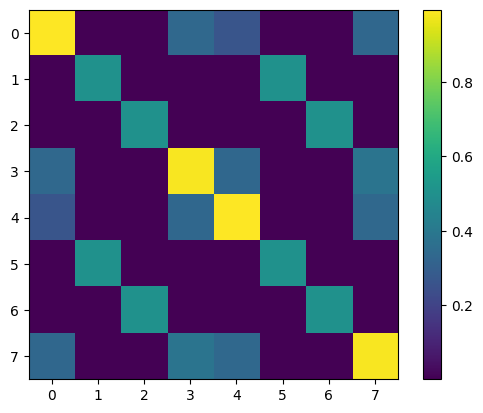

In [21]:
p_uv = np.zeros((nproj, nproj), dtype=COMPLEX_DTYPE)
for u in range(nproj):
    for v in range(nproj):
        asum = 0
        for t in range(nstates):
            asum2 = 0
            for j in range(nbands):
                asum2 += (proj_tju_for_s_uv[t, j, u].conj()*proj_tju_for_s_uv[t, j, v])*occ_tj[t, j]
            asum += asum2*wk_t[t]
        p_uv[u, v] = asum
plt.imshow(np.abs(p_uv))
plt.colorbar()
print(np.sum(p_uv, axis=(0,1)))
print(np.max(p_uv))

(13.481732+0j)
(9.999981+0j)
(1.1737958+0j)
(1.4811785+0j)
(1.4515167+0j)
(1.4515194+0j)
(0.61584157+0j)
(1.4811795+0j)
(1.4514594+0j)
(1.4514569+0j)
(0.61582947+0j)


[None, None, None, None, None, None, None, None]

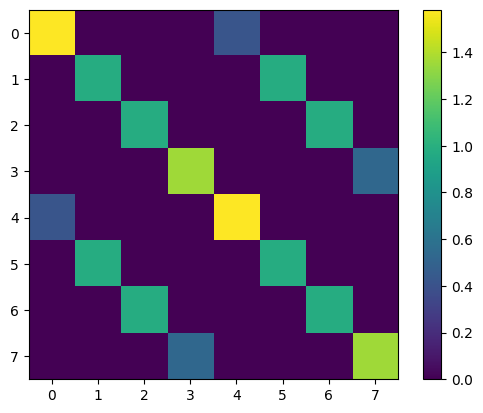

In [29]:
p_uv = np.zeros((nproj, nproj), dtype=COMPLEX_DTYPE)
for u in range(nproj):
    for v in range(nproj):
        asum = 0
        for t in range(nstates):
            asum2 = 0
            for j in range(nbands):
                asum2 += (0.5*(proj_tju[t, j, u].conj()*proj_tju[t, j, v] + proj_tju[t, j, v].conj()*proj_tju[t, j, u]))*occ_tj[t, j]
            asum += asum2*wk_t[t]
        p_uv[u, v] = asum
plt.imshow(np.abs(p_uv))
plt.colorbar()
p_uv_sum = np.sum(p_uv, axis=(0,1))
print(p_uv_sum)
p_uv *= nelec/p_uv_sum
print(np.sum(p_uv, axis=(0,1)))
print(np.max(p_uv))
[print(np.sum(p_uv[u], axis=0)) for u in range(nproj)]

In [ ]:
h_uv = np.zeros((nproj, nproj), dtype=COMPLEX_DTYPE)
